<a href="https://colab.research.google.com/github/richardgault/Automated-Ki-67-proliferation-scoring/blob/main/Ki67Net_McConnell_et_al_train_test_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Note: It is recommended that the path to your data directory contains no spaces

In [11]:
data_directory = input('Specify the directory where your data is stored (ending with / e.g drive/MyDrive/myfiles/are/here/): ')

Specify the directory where your data is stored (ending with / e.g drive/MyDrive/myfiles/are/here/): /content/drive/MyDrive/Machine_Learning/Mask_generation_real_data/IMVIP_data/


In [12]:
import os, cv2, io
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Use !pip when running notebook on Google Colab
!pip install segmentation-models-pytorch==0.1.3
!pip install -U segmentation-models-pytorch
!pip install albumentations==0.5.2
#!pip install pytorch_toolbelt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
from PIL import Image, ImageDraw, ImageFilter
import gc
from torchsummary import summary
import csv

from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from math import sqrt
import base64
import imutils
import cv2
import torchvision.transforms as transforms

     |████████████████████████████████| 71kB 2.5MB/s 
     |████████████████████████████████| 61kB 5.6MB/s 
     |████████████████████████████████| 245kB 11.0MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=a970fc932a4b14801c551f9ce17a5be6a22eb8c0a17bd8882f97f10a0c9365c9
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=38242cd0468753e5ffc2688532e2f4fc87262a64f877c4fb669ad8f855cdb402
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch
Requirement already up-to-date: segmentation-models-pytorch in /usr/local/lib/python3.7/dist-packages (0.1.3)
     |████████████████████████████████| 81kB 2.6MB/s 
     |████████████████████████████████| 952kB 4.3MB

In [13]:
# Dataset class
class CellDataset(torch.utils.data.Dataset):
    """Read images from directory, apply augmentation and preprocessing.
    
    Arguments
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transformation pipeline 
        preprocessing (albumentations.Compose): data preprocessing 
    """

    def __init__(
        self, 
        images_dir, 
        masks_dir, 
        class_rgb_values=None, 
        augmentation=None, 
        preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # encode the mask
        mask = encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.image_paths)

In [21]:
# Perform colour coding on the reverse-encoded outputs
def segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

In [15]:
def count_cells(mask):
  #mask = np.transpose(mask,(1,2,0))
  #select_class_rgb_values = [[0, 0, 0],[128, 128, 128],[255, 255, 255]]
  #mask = segmentation(reverse_encode(mask), select_class_rgb_values)

  # Convert image to base64
  output_img = Image.fromarray(mask.astype("uint8"))
  rawBytes = io.BytesIO()
  output_img.save(rawBytes, "PNG")
  rawBytes.seek(0)
  img_base64 = base64.b64encode(rawBytes.read()).decode('utf-8')

  tensor_to_img = transforms.ToPILImage()(mask.astype("uint8")).convert("RGB")
  gray = cv2.cvtColor(np.array(tensor_to_img),cv2.COLOR_RGB2GRAY)
  thresh_gaussian = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)                                      

  # Find the contours
  contours = cv2.findContours(thresh_gaussian.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours = imutils.grab_contours(contours)

  # Count number of healthy and Ki67 cells
  ki67_counter = 0
  normal_cell_counter = 0
  for c in contours:
      M = cv2.moments(c)
      if(M["m00"]!=0):
          cX = int(M["m10"] / M["m00"])
          cY = int(M["m01"] / M["m00"])
          if tensor_to_img.getpixel((cX,cY)) == (255,255,255):
              ki67_counter = ki67_counter + 1
          elif tensor_to_img.getpixel((cX,cY)) == (128,128,128):
              normal_cell_counter = normal_cell_counter + 1
          # cX = int(M["m10"] / M["m00"])
          # cY = int(M["m01"] / M["m00"])
          # if gray[cX,cY] == 255:
          #     ki67_counter = ki67_counter + 1
          # elif gray[cX,cY] == 128:
          #     normal_cell_counter = normal_cell_counter + 1
      else:
          cX,cY = 0,0
  return normal_cell_counter,ki67_counter

In [16]:
def write_csv(output_name,data_array):
  with open(output_name, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["GT Normal cells", "GT Ki67 cells","Pred Normal cells", "Pred Ki67 cells"])
    for x in data_array:      
      writer.writerow(x)

In [17]:
def boundary_confusion_matrix(all_counts):
  gt_grouping = []
  pred_groupings = []
  for c in all_counts:
    if (c[1]/(c[0]+c[1]))<=0.1: 
      gt_grouping.append(1);
    elif (c[1]/(c[0]+c[1]))<=0.2:
      gt_grouping.append(2);
    else:
      gt_grouping.append(3);

    if (c[3]/(c[2]+c[3]))<=0.1:
      pred_groupings.append(1);
    elif (c[3]/(c[2]+c[3]))<=0.2:
      pred_groupings.append(2);
    else:
      pred_groupings.append(3);
 
  #print(gt_grouping)
  #print(pred_groupings)
  print("--------------------")
  print("Boundary Matrix")
  print(confusion_matrix(gt_grouping, pred_groupings))
  print(classification_report(gt_grouping, pred_groupings, digits=3))
  print("--------------------")

In [18]:
# Helper function for data visualisation
def visualize(**images):
    """
    Plot images horizontally
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [19]:
# Perform encoding on label (mask to one-hot)
def encode(label, label_values):
    """
    Convert a segmentation mask (H, W, C) to (H, W, K) where the last dimension is a one
    hot encoding vector, where C = number of channels, and K = number of classes.
    Replaces each pixel value with a vector of length num_classes

    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map

In [20]:
# Perform reverse encoding on labels or predictions (one-hot to mask)
def reverse_encode(image):
    """
    Transform a 2D array in encoded format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key. 
    Convert a mask (H, W, K) to (H, W, C), where K = number of classes and C = number of channels
    # Arguments
        image: The encoded image 
        
    # Returns
        A 2D array with the same width and height as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x


# Data Pre-processing

In [24]:
# Apply preprocessing
def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Arguments
        preprocessing_fn : data normalization function 
    Returns
        transform: albumentations.Compose
    """   
    if preprocessing_fn:
      _transform = [
        album.Lambda(image=preprocessing_fn),
        album.Lambda(image=to_tensor, mask=to_tensor),
    ]
    else:
      _transform = [
        album.Lambda(image=to_tensor, mask=to_tensor),
    ]
        
    return album.Compose(_transform)

In [25]:
# Convert to Tensor
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [26]:
# Center crop padded image to original dimensions
def crop_image(image, target_image_dims=[256,256,3]):
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2
    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [23]:
def get_validation_augmentation():   
    # Add padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)

In [22]:
# Augmentation methods for dataset

def get_training_augmentation():
    train_transform = [    
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)

# Main body of code

## Data format

It is assumed that within the main data directory (entered previously) that the datasets are in the following directory structure

*Dataset directory*

*   train

    ->image1.jpeg

    ->image2.jpeg

    ->...
    
*   train_labels

    ->image1.json

    ->image2.json

    ->...
    
*   test

    ->imageT1.jpeg

    ->imageT2.jpeg

    ->...
    
*   test_labels

    ->imageT1.json

    ->imageT2.json

    ->...
    
*   validation

    ->imageV1.jpeg

    ->imageV2.jpeg

    ->...
    
*   validation_labels

    ->imageV1.json

    ->imageV2.json

    ->...

#Note

label_class_dict.csv must be saved in the same directory as the data.

In [28]:
results_directory = data_directory+'results/'
if not os.path.isdir(results_directory):  
  os.mkdir(results_directory)
  print('Created a new Results folder')
training_images = os.path.join(data_directory, 'train_png')
training_labels = os.path.join(data_directory, 'train_masks')
validation_images = os.path.join(data_directory, 'validation_png')
validation_labels = os.path.join(data_directory, 'validation_masks')
test_images = os.path.join(data_directory, 'test_png')
test_labels = os.path.join(data_directory, 'test_masks')

class_dict = pd.read_csv(data_directory+"label_class_dict.csv")
class_names = class_dict['name'].tolist()
class_rgb_values = class_dict[['r','g','b']].values.tolist()

select_classes = ['background', 'cell_healthy', 'cell_ki67']
select_class_rgb_values =   [[  0,   0,   0], [128, 128, 128], [255, 255, 255]]
print('Dataset classes: ', select_classes)
print('RGB values: ', select_class_rgb_values)
    
# Create segmentation model with pretrained ResNet50 encoder as backbone

encoder = 'resnet50'
encoder_weights = 'imagenet'
classes = class_names
activation = 'softmax' 

model = smp.Unet(
    encoder_name=encoder, 
    encoder_weights=encoder_weights, 
    classes=len(classes), 
    activation=activation,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_weights)

# Initialising training and validation data loaders
train_dataset = CellDataset(
    training_images, training_labels, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = CellDataset(
    validation_images, validation_labels, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

dataset = CellDataset(training_images, training_labels, class_rgb_values=select_class_rgb_values)

print("\nNumber of training images:",len(os.listdir(training_images)))
print("\nNumber of training masks:",len(os.listdir(training_labels)))
print("\nNumber of training validation images:",len(os.listdir(validation_images)))
print("\nNumber of training validation masks:",len(os.listdir(validation_labels)))
# Set variables for model

trainingMode = True   # Flag for running model training, 'False' = only prediction is performed
epochs = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("\nDevice being used:\n", device)
model = model.to(device)
loss = smp.utils.losses.DiceLoss()

print("\nMODEL INFO:\n", model)
print("\nMODEL SUMMARY:\n")
summary(model, input_size=(3, 256, 256))

metrics = [
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.Precision(),
    smp.utils.metrics.Recall(),
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(),
]

optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001),])
    
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

model_path = results_directory+'best_model.pth'
model_dictionary_path = results_directory+'model_dictionary.pth'

best_iou_score = 0.0
      
# Load best saved model checkpoint from the current run
if os.path.exists(model_path):
  best_model = torch.load(model_path, map_location=device)
  print('Loaded model from current run')


train_logs_list, valid_logs_list = [], []

if trainingMode:
  for i in range(epochs):
    # Perform training & validation
    print('\nEpoch (real-life dataset): {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    validation_logs = valid_epoch.run(valid_loader)
    train_logs_list.append(train_logs)
    valid_logs_list.append(validation_logs)

    # Save model and dictionary if a better IoU score is obtained
    if best_iou_score < validation_logs['iou_score']:
      best_iou_score = validation_logs['iou_score']
      torch.save(model, model_path)
      torch.save(model.state_dict(), model_dictionary_path)
      torch.save(model.state_dict(), results_directory+"model_dictionary-new.pth")
      print('Model and dictionary saved')

      # Optimising memory usage for GPU    
      gc.collect()
      torch.cuda.empty_cache()


Created a new Results folder
Dataset classes:  ['background', 'cell_healthy', 'cell_ki67']
RGB values:  [[0, 0, 0], [128, 128, 128], [255, 255, 255]]

Number of training images: 1257

Number of training masks: 1257

Number of training validation images: 320

Number of training validation masks: 320

Device being used:
 cuda:0

MODEL INFO:
 Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

#Testing Section


Number of test images: 395

Number of test masks: 395
Loaded model from current run


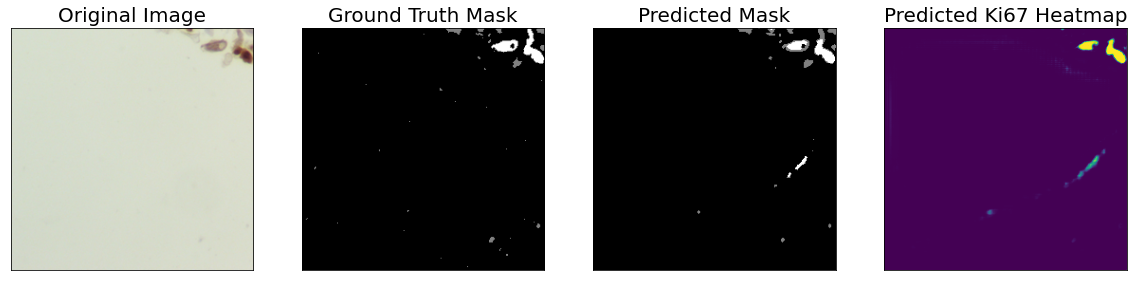

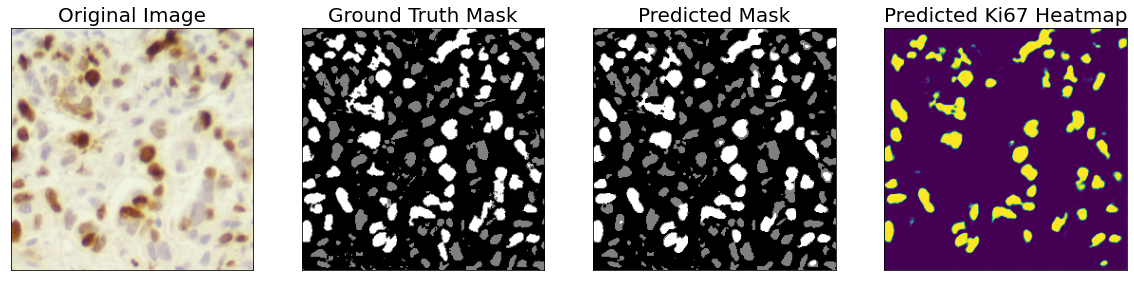

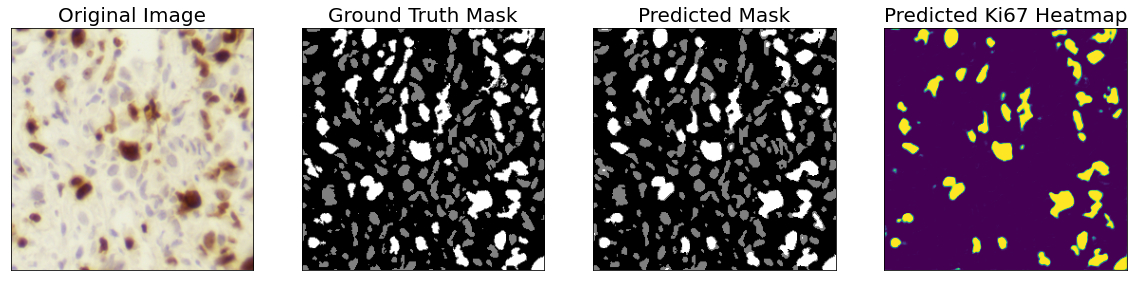

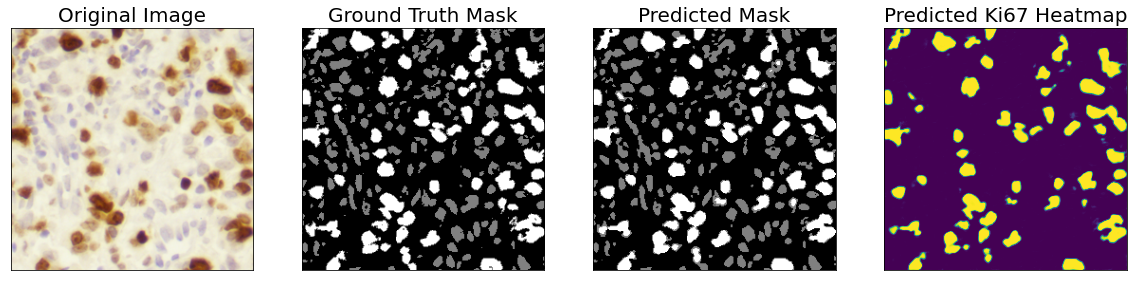

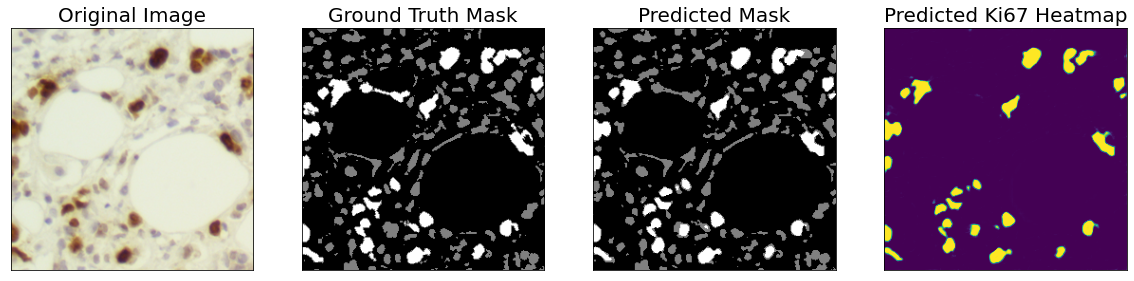

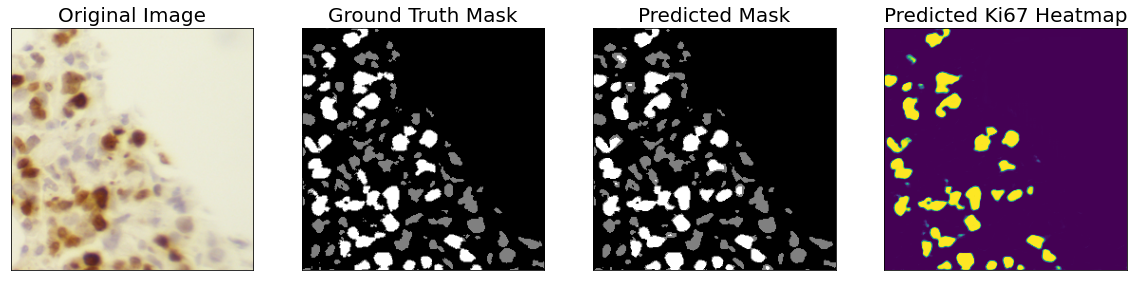

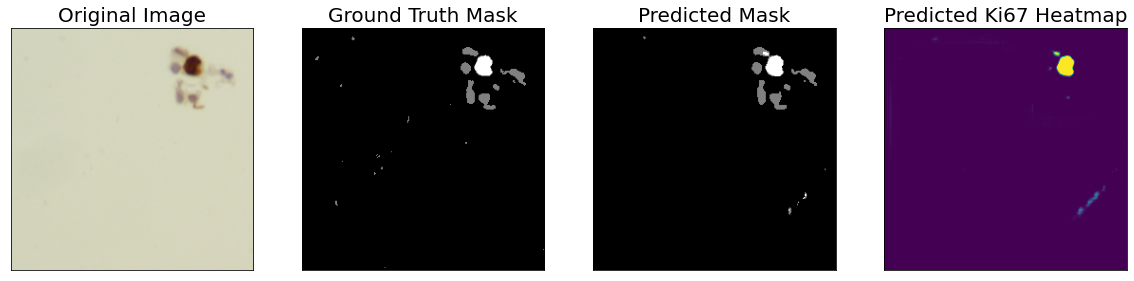

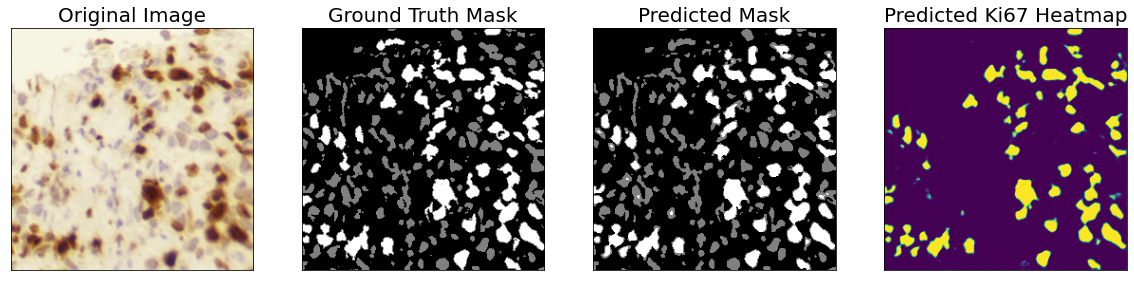

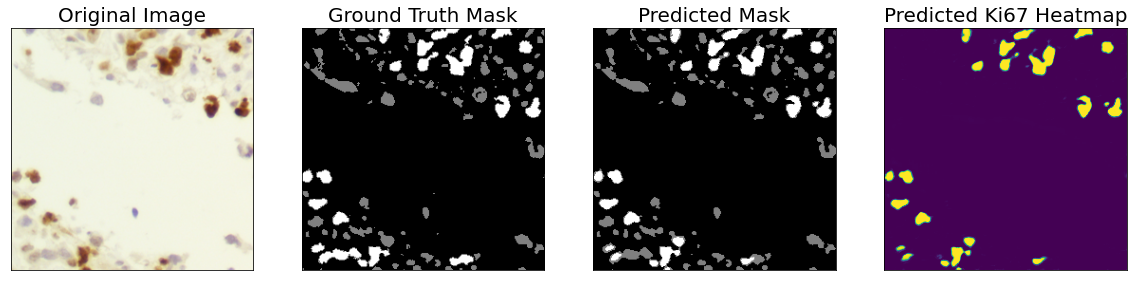

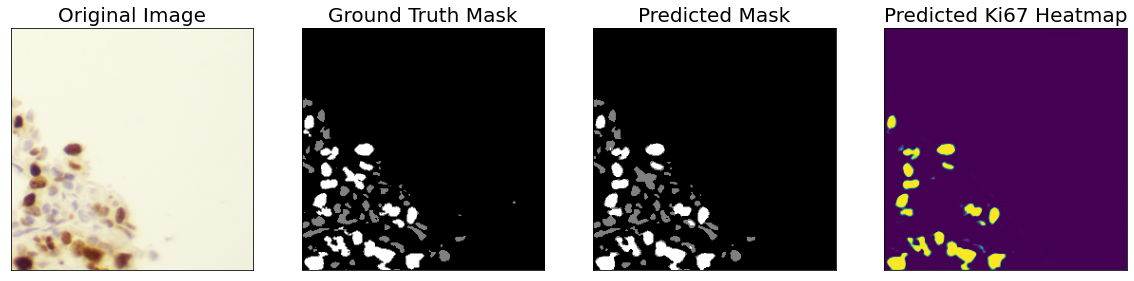

In [30]:
print("\nNumber of test images:",len(os.listdir(test_images)))
print("\nNumber of test masks:",len(os.listdir(test_labels)))

# Load best saved model checkpoint from the current run
if os.path.exists(model_path):
    best_model = torch.load(model_path, map_location=device)
    print('Loaded model from current run')

# Initialising test dataloader 
test_dataset = CellDataset(
    test_images, 
    test_labels, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# Test dataset for visualization (without preprocessing transformations)
test_dataset_vis = CellDataset(
    test_images, test_labels, 
    augmentation=get_validation_augmentation(), 
    class_rgb_values=select_class_rgb_values,
)

sample_predictions_directory = results_directory+'sample_predictions/'
if not os.path.exists(sample_predictions_directory):
    os.makedirs(sample_predictions_directory)
    print(['Made directory for predictions at: ',sample_predictions_directory])
    
# Display predicted masks for 10 of the test images from the real-life dataset
all_counts = [];
for idx in np.arange(min(len(test_dataset),10)):#...or all data with len(test_dataset_real)):
    image, groundTruth_mask = test_dataset[idx]
    image_visual = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    image_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(image_tensor)
    # output = pred_mask.squeeze(0)
    # output_predictions = output.argmax(0)
    # print("output predictions",output_predictions)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert prediction mask from CHW format to HWC format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to Ki67
    pred_Ki67_heatmap = pred_mask[:,:,select_classes.index('cell_ki67')]
    pred_mask = crop_image(segmentation(reverse_encode(pred_mask), select_class_rgb_values))

    # Convert ground truth mask from CHW format to HWC format
    groundTruth_mask = np.transpose(groundTruth_mask,(1,2,0))
    groundTruth_mask = crop_image(segmentation(reverse_encode(groundTruth_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_predictions_directory, f"sample_pred_{idx+1}.png"), np.hstack([image_visual, groundTruth_mask, pred_mask])[:,:,::-1])
    
    # Get ground truth counts
    GT_normal_cell_counter,GT_ki67_counter = count_cells(groundTruth_mask)
    #Get predicted counts
    Pred_normal_cell_counter,Pred_ki67_counter = count_cells(pred_mask)
    all_counts.append([GT_normal_cell_counter,GT_ki67_counter,Pred_normal_cell_counter,Pred_ki67_counter])

    if idx<25:
      visualize(
        original_image = image_visual,
        ground_truth_mask = groundTruth_mask,
        predicted_mask = pred_mask,
        predicted_Ki67_heatmap = pred_Ki67_heatmap
        )

In [31]:
#print summary of counts
normal_GT = [r[0] for r in all_counts]
Ki67_GT =[r[1] for r in all_counts]
normal_pred = [r[2] for r in all_counts]
Ki67_pred = [r[3] for r in all_counts]
print(["RMSE Normal ", sqrt(mean_squared_error(normal_GT, normal_pred))])
print(["RMSE Ki67 ", sqrt(mean_squared_error(Ki67_GT, Ki67_pred))])
print(["RMSE ratio ", sqrt(mean_squared_error(np.divide(Ki67_GT,np.add(normal_GT,Ki67_GT)),np.divide(Ki67_pred,np.add(normal_pred,Ki67_pred))))])
boundary_confusion_matrix(all_counts)
#save counts to file
write_csv(results_directory+"count_results.csv",all_counts)
# Perform testing

test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)



testing_logs = test_epoch.run(test_dataloader)
test_logs_list = []
test_logs_list.append(testing_logs)

print("\nEvaluating test data for images: ")
print(f"Mean Dice Loss: {testing_logs['dice_loss']:.4f}")
print(f"Mean IoU Score: {testing_logs['iou_score']:.4f}")
print(f"Mean Accuracy: {testing_logs['accuracy']:.4f}")
print(f"Mean Precision: {testing_logs['precision']:.4f}")
print(f"Mean Recall: {testing_logs['recall']:.4f}")

# Convert data lists to dataframes, then transpose index and columns
train_logs_df = pd.DataFrame(train_logs_list)
train_validation_logs_df = pd.DataFrame(valid_logs_list)
testing_logs_df = pd.DataFrame(test_logs_list)
train_logs_df.T 
print("\nTraining data summary\n",train_logs_df)
print("\nValidation during training data summary\n",train_validation_logs_df)
print("\nTesting data summary\n",testing_logs_df)

['RMSE Normal ', 9.757048734120374]
['RMSE Ki67 ', 1.3038404810405297]
['RMSE ratio ', 0.03332294485090913]
--------------------
Boundary Matrix
[[0 0 0]
 [1 4 0]
 [0 0 5]]
              precision    recall  f1-score   support

           1      0.000     0.000     0.000         0
           2      1.000     0.800     0.889         5
           3      1.000     1.000     1.000         5

    accuracy                          0.900        10
   macro avg      0.667     0.600     0.630        10
weighted avg      1.000     0.900     0.944        10

--------------------
valid: 100%|██████████| 395/395 [02:48<00:00,  2.34it/s, dice_loss - 0.07072, accuracy - 0.9596, precision - 0.9399, recall - 0.9387, iou_score - 0.8925, fscore - 0.9393]

Evaluating test data for images: 
Mean Dice Loss: 0.0707
Mean IoU Score: 0.8925
Mean Accuracy: 0.9596
Mean Precision: 0.9399
Mean Recall: 0.9387

Training data summary
    dice_loss  accuracy  precision    recall  iou_score    fscore
0   0.277781  0.895

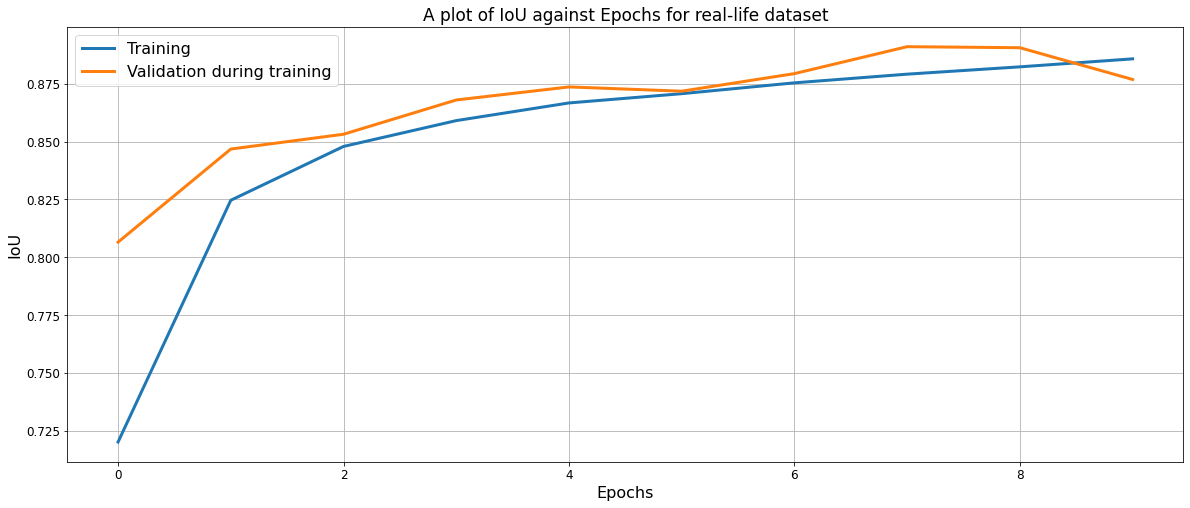

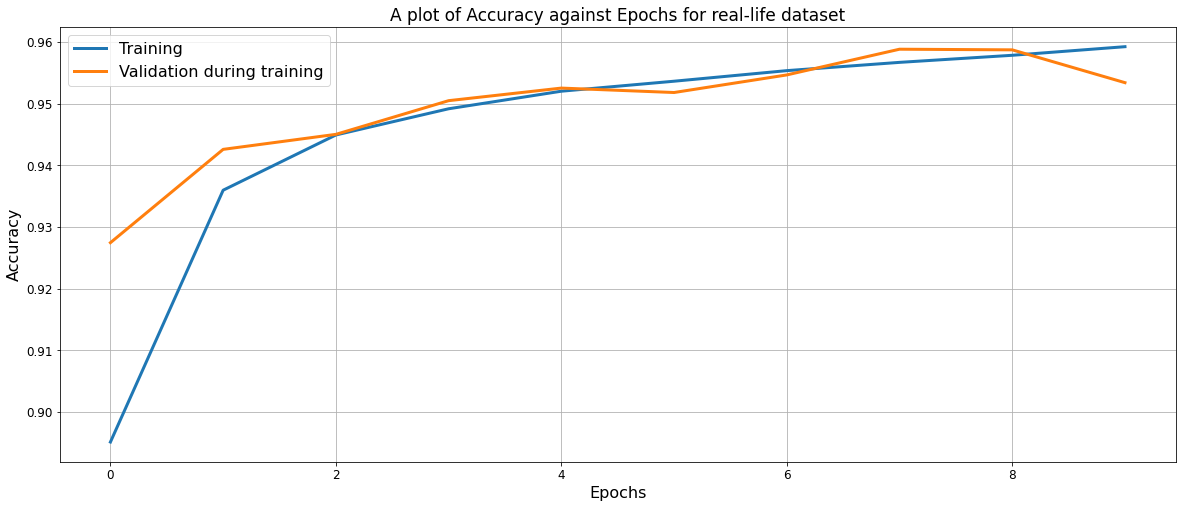

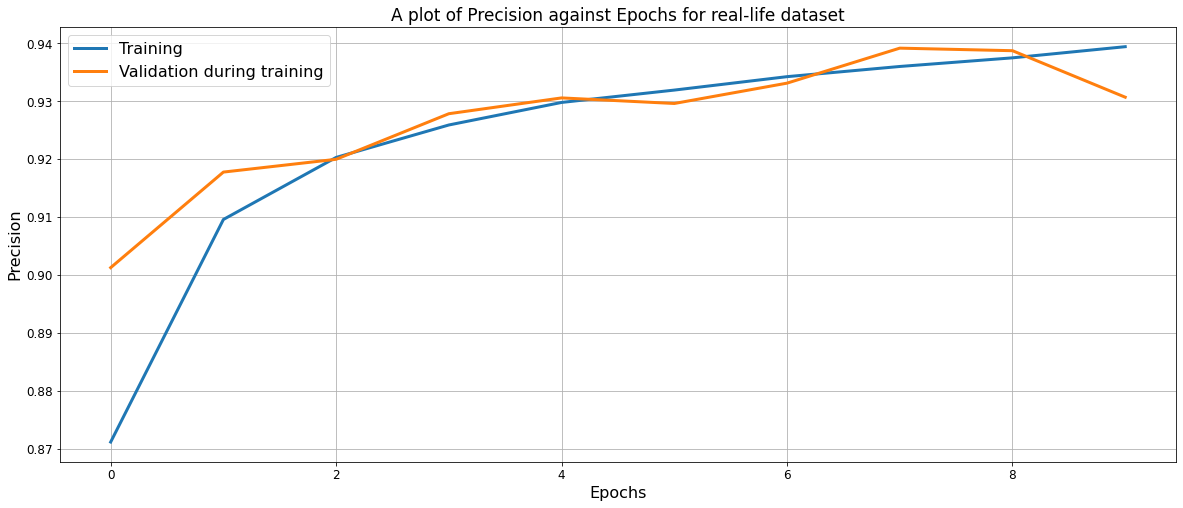

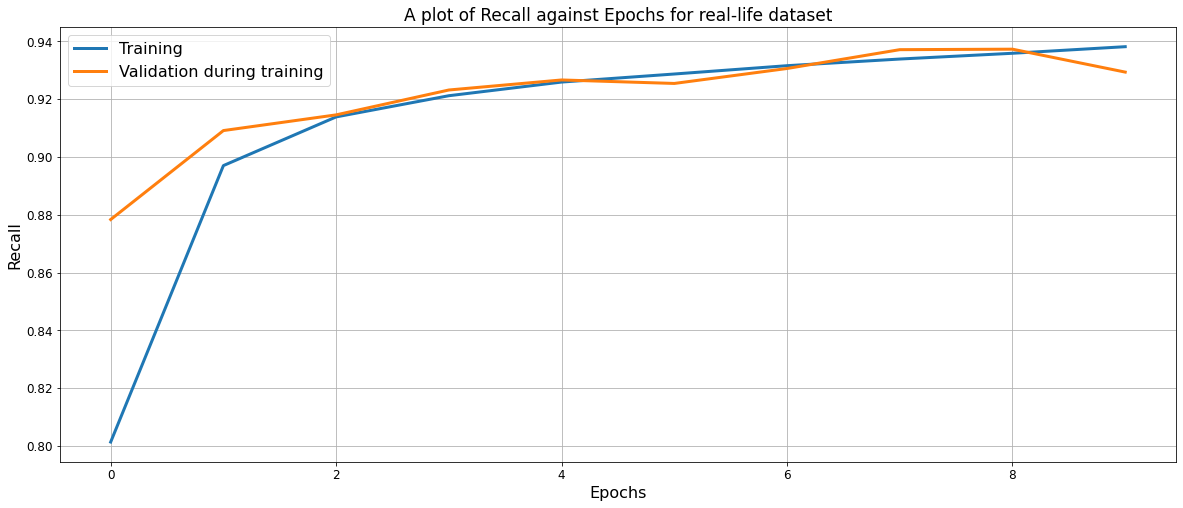

In [32]:
# Visualisation of model performance comparing different metrics for real-life dataset

plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Training')
plt.plot(train_validation_logs_df.index.tolist(), train_validation_logs_df.iou_score.tolist(), lw=3, label = 'Validation during training')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('IoU', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('A plot of IoU against Epochs for real-life dataset', fontsize=17)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.accuracy.tolist(), lw=3, label = 'Training')
plt.plot(train_validation_logs_df.index.tolist(), train_validation_logs_df.accuracy.tolist(), lw=3, label = 'Validation during training')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('A plot of Accuracy against Epochs for real-life dataset', fontsize=17)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('accuracy_plot.png')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.precision.tolist(), lw=3, label = 'Training')
plt.plot(train_validation_logs_df.index.tolist(), train_validation_logs_df.precision.tolist(), lw=3, label = 'Validation during training')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('A plot of Precision against Epochs for real-life dataset', fontsize=17)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('precision_plot.png')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.recall.tolist(), lw=3, label = 'Training')
plt.plot(train_validation_logs_df.index.tolist(), train_validation_logs_df.recall.tolist(), lw=3, label = 'Validation during training')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('A plot of Recall against Epochs for real-life dataset', fontsize=17)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('recall_plot.png')
plt.show()

In [33]:
boundary_confusion_matrix(all_counts)

--------------------
Boundary Matrix
[[0 0 0]
 [1 4 0]
 [0 0 5]]
              precision    recall  f1-score   support

           1      0.000     0.000     0.000         0
           2      1.000     0.800     0.889         5
           3      1.000     1.000     1.000         5

    accuracy                          0.900        10
   macro avg      0.667     0.600     0.630        10
weighted avg      1.000     0.900     0.944        10

--------------------
